In [7]:
#Prepared by:
#H M AHSAN HABIB KUSHAL
#AMARTYA CHOWDHURY

In [13]:
#Imports
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss, confusion_matrix
from sklearn.ensemble import VotingClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings('ignore')


In [2]:
#lOAD DATA

N_SPLITS = 10
RANDOM_STATE = 42
TARGET_COL = "Status"

# Local data directory (your Windows path)
DATA_DIR = "C:/Users/H. M. Ahsan Habib/BAIC_2025_NITER_SOYUZ/"

# Load data
try:
    train_df = pd.read_csv(DATA_DIR + "train.csv")
    test_df = pd.read_csv(DATA_DIR + "test.csv")
    print("Data loaded successfully.")
    print(f"Train shape: {train_df.shape} | Test shape: {test_df.shape}")
except FileNotFoundError:
    raise FileNotFoundError(f"Error: train.csv or test.csv not found at: {DATA_DIR}")

# Sanity check
if TARGET_COL not in train_df.columns:
    raise KeyError(f"Target column '{TARGET_COL}' not found in train.csv")

# Keep test ids before combining
test_ids = test_df["id"]

# Mark datasets
train_df["is_test"] = 0
test_df["is_test"] = 1

# Store target variable
y = train_df[TARGET_COL]

# Combine without target
data = pd.concat([train_df.drop(columns=[TARGET_COL]), test_df], ignore_index=True)

print(f"Combined data shape (train + test): {data.shape}")
print(f"Columns (first 10): {list(data.columns)[:10]} ...")

# Preview
train_df.head()


Data loaded successfully.
Train shape: (15000, 20) | Test shape: (10000, 19)
Combined data shape (train + test): (25000, 20)
Columns (first 10): ['id', 'N_Days', 'Drug', 'Age', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Bilirubin'] ...


,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,...,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status,is_test
0,0,859.0,Placebo,17841.0,F,N,Y,N,N,2.1,...,3.70,74.0,2148.0,136.74,144.0,298.0,11.0,4.0,D,0
1,1,1141.0,Placebo,18102.0,F,N,Y,Y,S,2.1,...,3.48,4.0,918.0,120.90,90.0,213.0,12.4,2.0,D,0
2,2,853.0,D-penicillamine,16728.0,F,N,Y,Y,N,5.7,...,3.67,161.0,11552.0,136.74,165.0,102.0,11.5,4.0,D,0
3,3,1785.0,D-penicillamine,19358.0,F,N,Y,N,N,2.1,...,3.36,74.0,661.0,272.80,231.0,166.0,11.4,4.0,D,0
4,4,1418.0,Placebo,22306.0,F,N,Y,Y,S,2.0,...,3.74,86.0,13862.4,136.00,114.0,339.0,11.0,4.0,D,0


Running enhanced EDA...
Shape: (15000, 21)

Data Types:
 id                 int64
N_Days           float64
Drug              object
Age              float64
Sex               object
Ascites           object
Hepatomegaly      object
Spiders           object
Edema             object
Bilirubin        float64
Cholesterol      float64
Albumin          float64
Copper           float64
Alk_Phos         float64
SGOT             float64
Tryglicerides    float64
Platelets        float64
Prothrombin      float64
Stage            float64
Status            object
is_test            int64
dtype: object

Head:
    id  N_Days             Drug      Age Sex Ascites Hepatomegaly Spiders  \
0   0   859.0          Placebo  17841.0   F       N            Y       N   
1   1  1141.0          Placebo  18102.0   F       N            Y       Y   
2   2   853.0  D-penicillamine  16728.0   F       N            Y       Y   
3   3  1785.0  D-penicillamine  19358.0   F       N            Y       N   
4   4  1418.0   

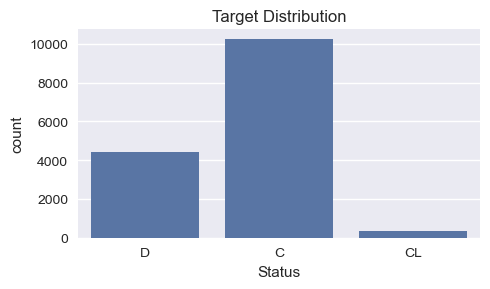


Target Class Percentages:
 Status
C     68.226667
D     29.486667
CL     2.286667
Name: proportion, dtype: float64

Numeric Stats (with skew & kurtosis):
                 count          mean          std     min       25%       50%  \
id             15000.0   7499.500000  4330.271354    0.00   3749.75   7499.50   
N_Days         15000.0   1961.488320  1269.332490    3.00   1095.00   1783.00   
Age            15000.0  19297.116020  3676.911840  133.30  16714.00  19358.00   
Bilirubin      15000.0      1.873353     2.821977    0.30      0.60      0.90   
Cholesterol     6623.0    326.345342   188.022395   66.00    242.00    280.00   
Albumin        15000.0      3.521489     0.376376    1.96      3.29      3.58   
Copper          8338.0     75.533329    76.301928    1.00     31.00     52.00   
Alk_Phos        8450.0   1635.588473  1823.745780  289.00    718.00   1072.00   
SGOT            8446.0    105.608583    49.984298    0.60     70.00     97.65   
Tryglicerides   6574.0    109.53407

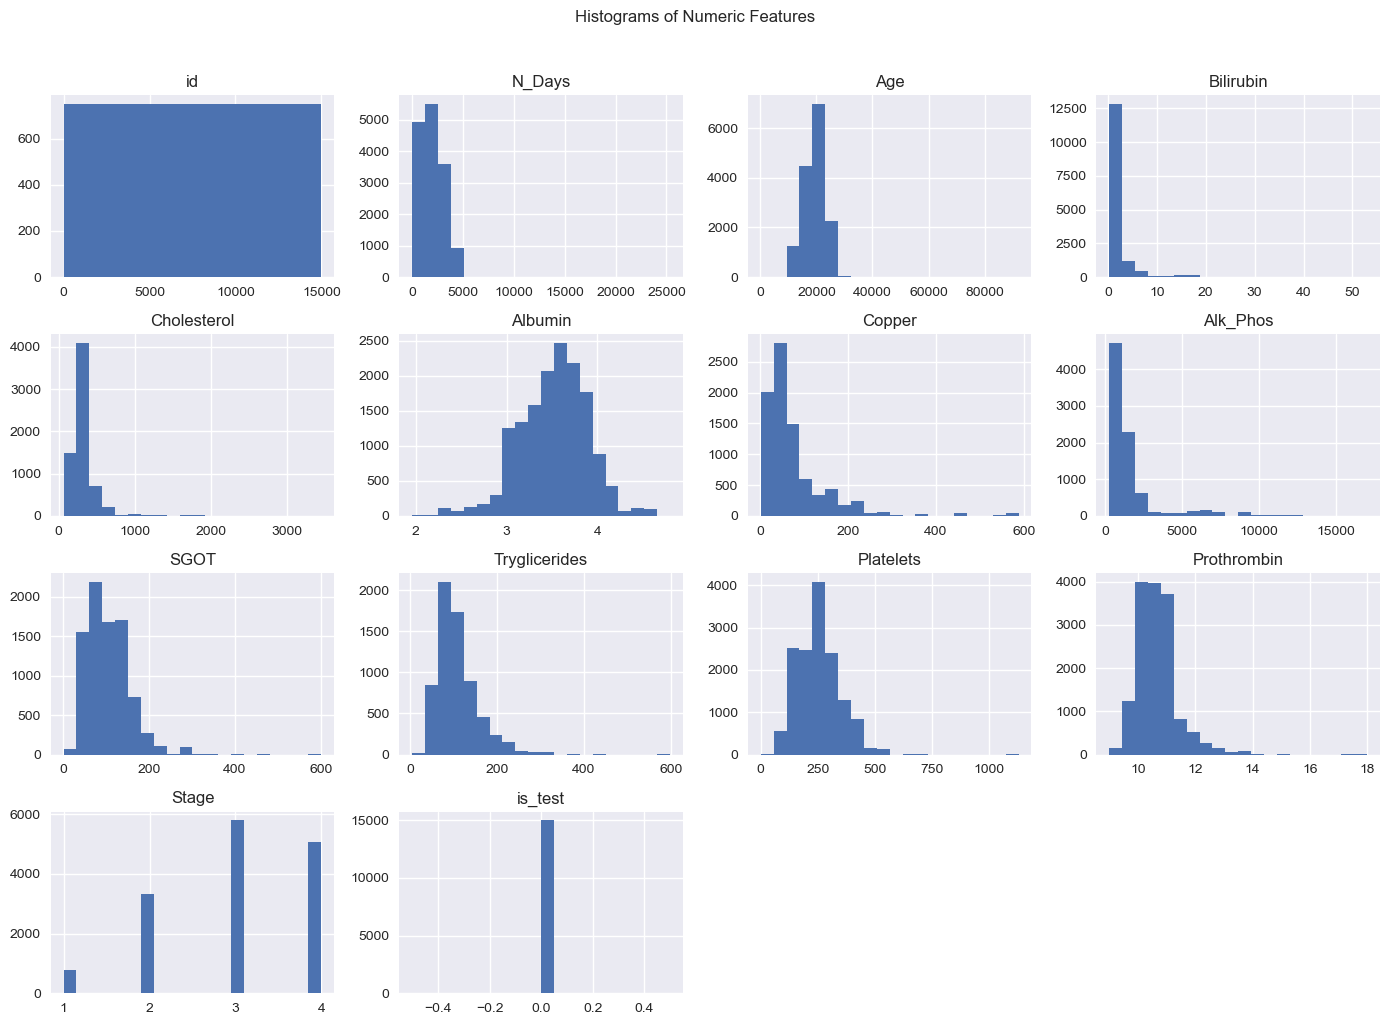

<Figure size 1400x840 with 0 Axes>

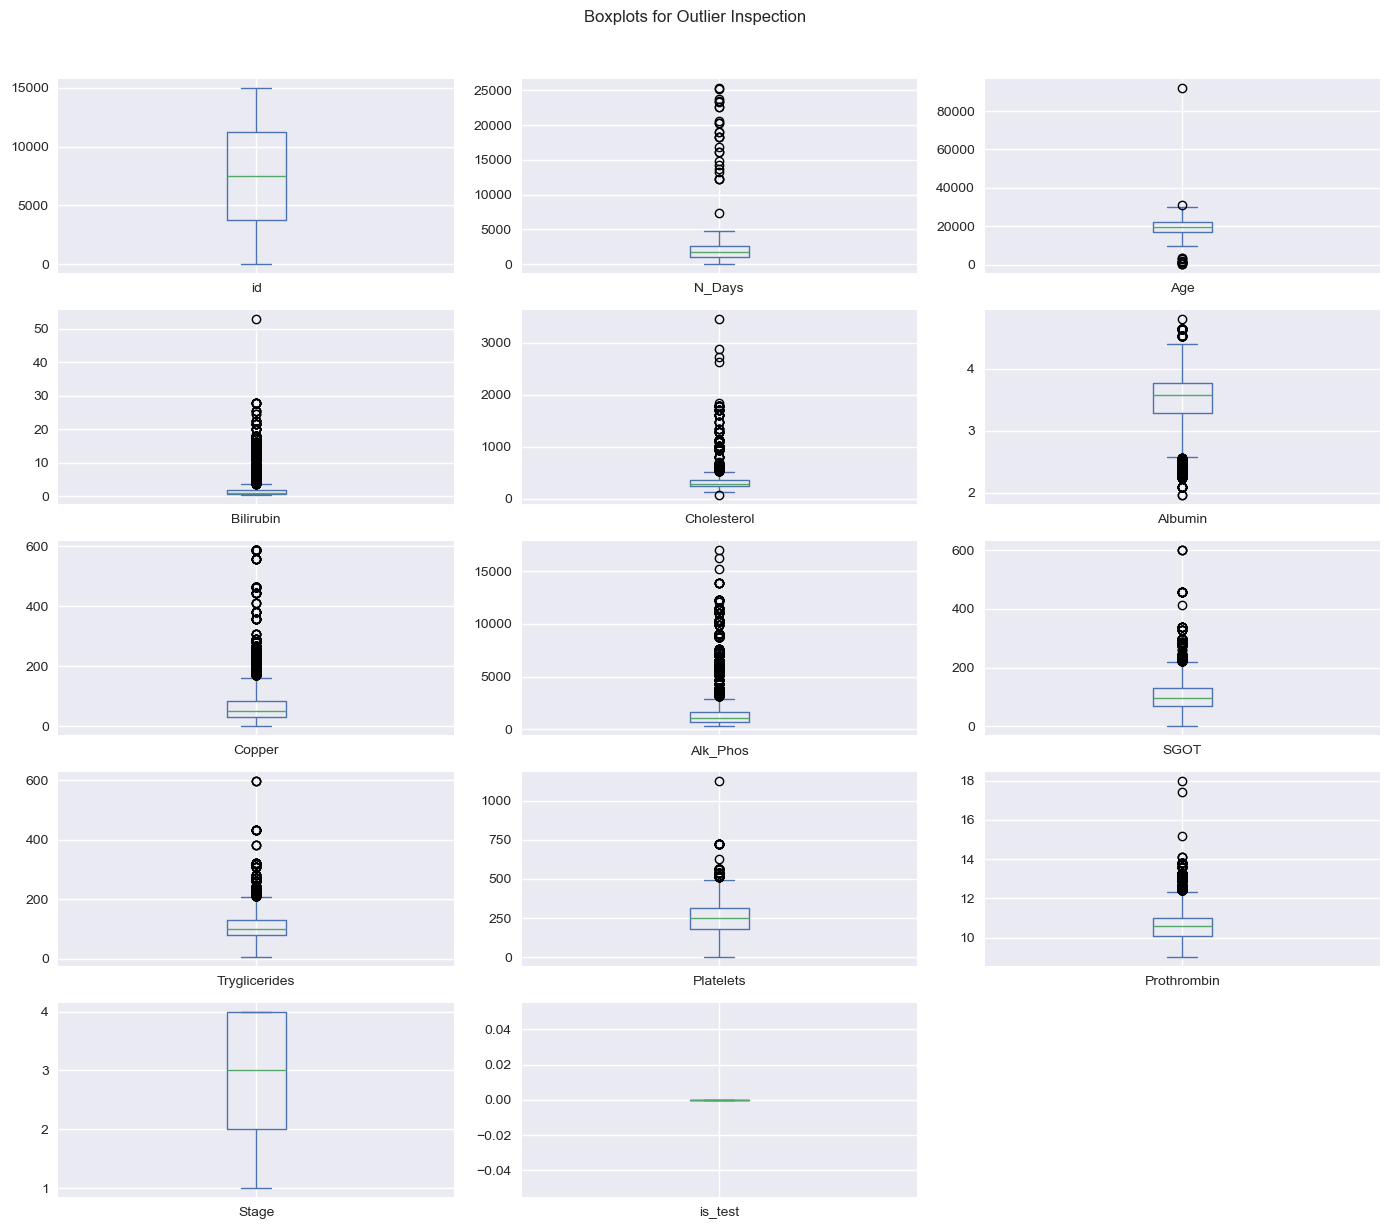

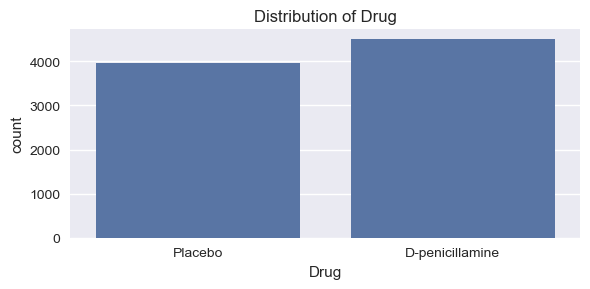

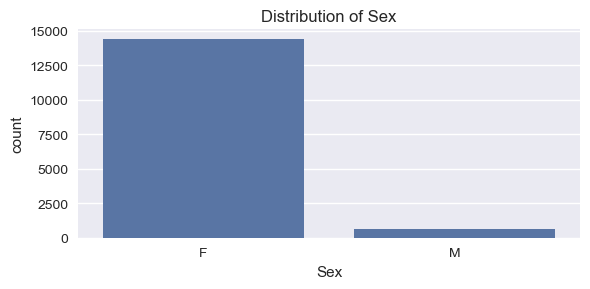

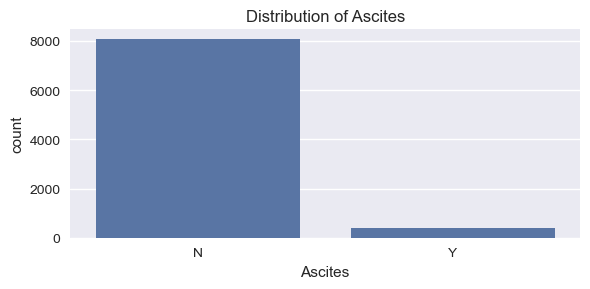

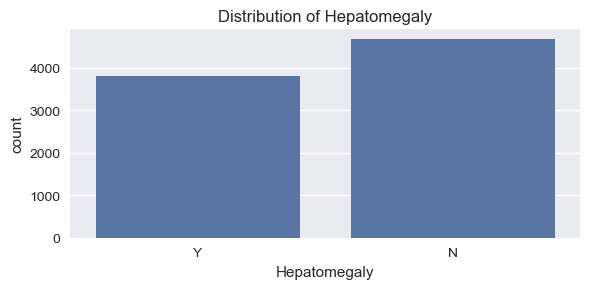

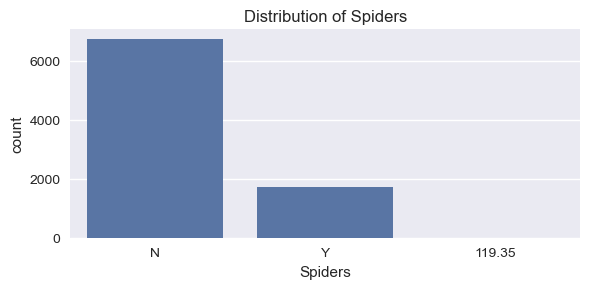

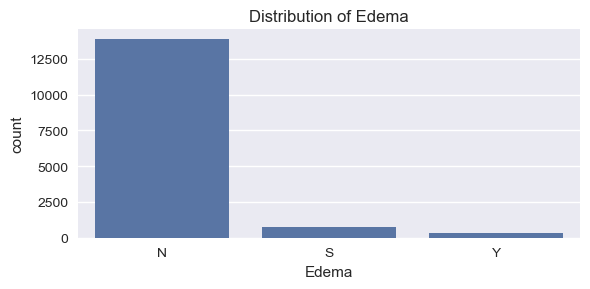

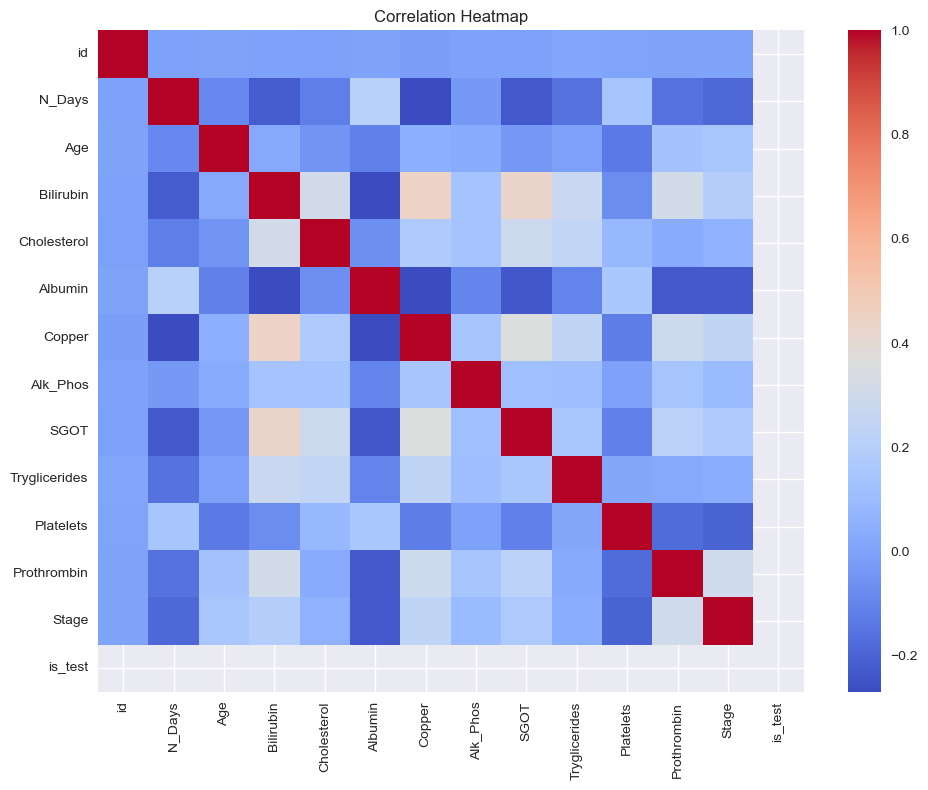

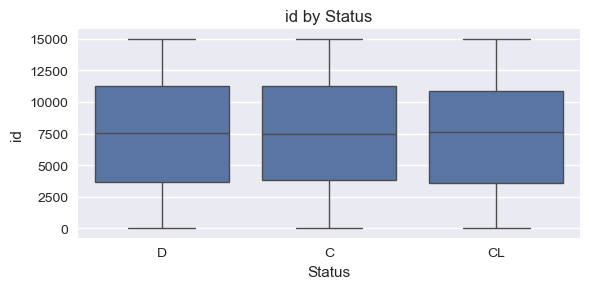

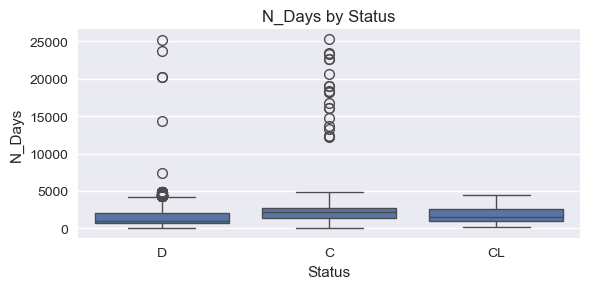

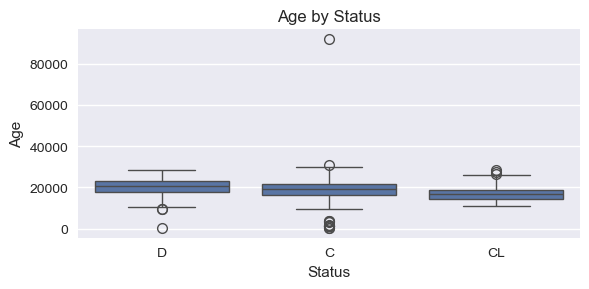

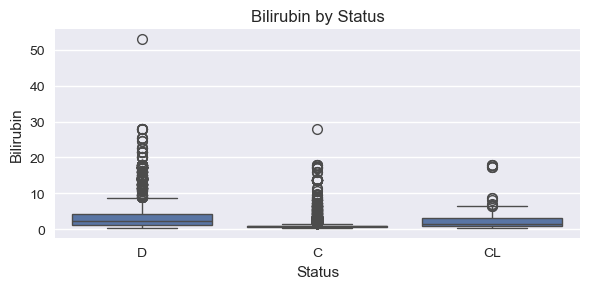

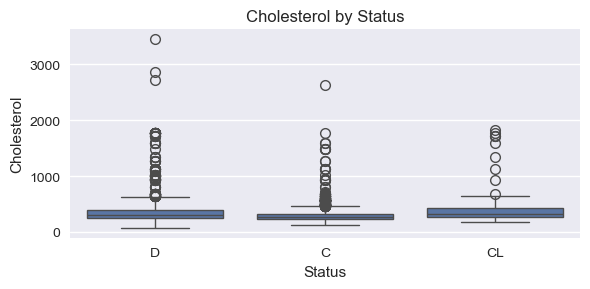

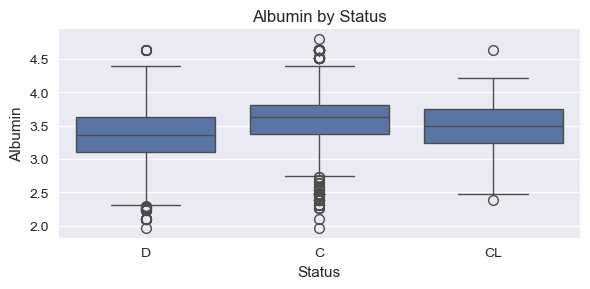

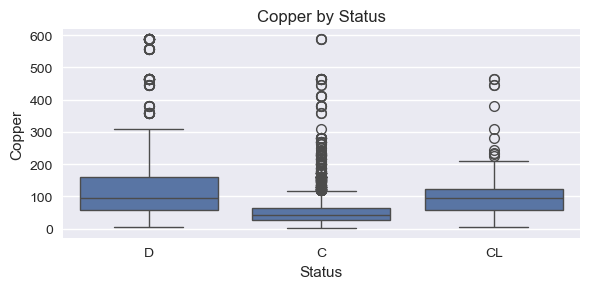

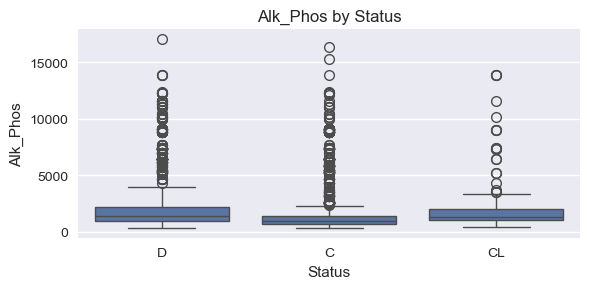

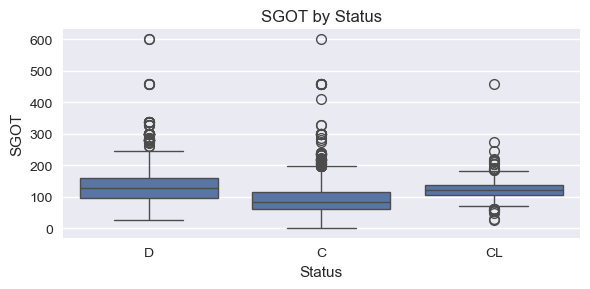

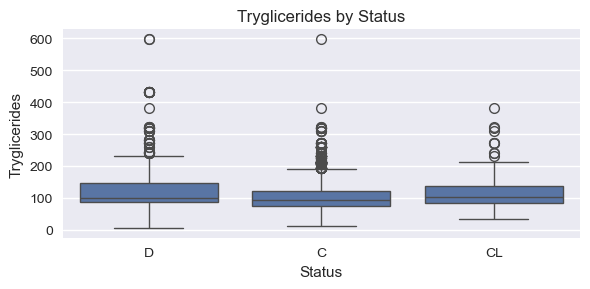

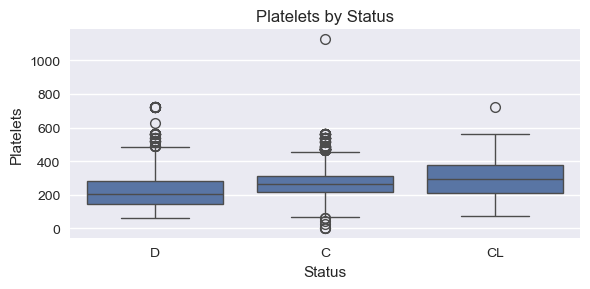

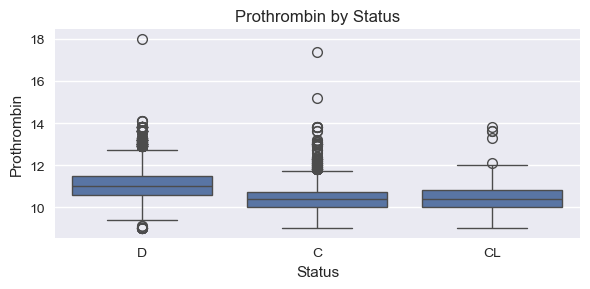

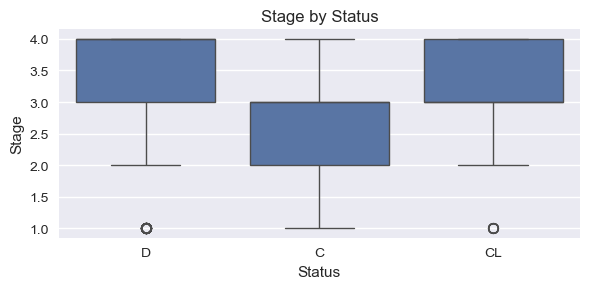

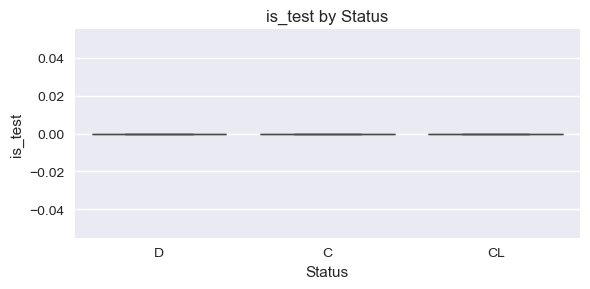

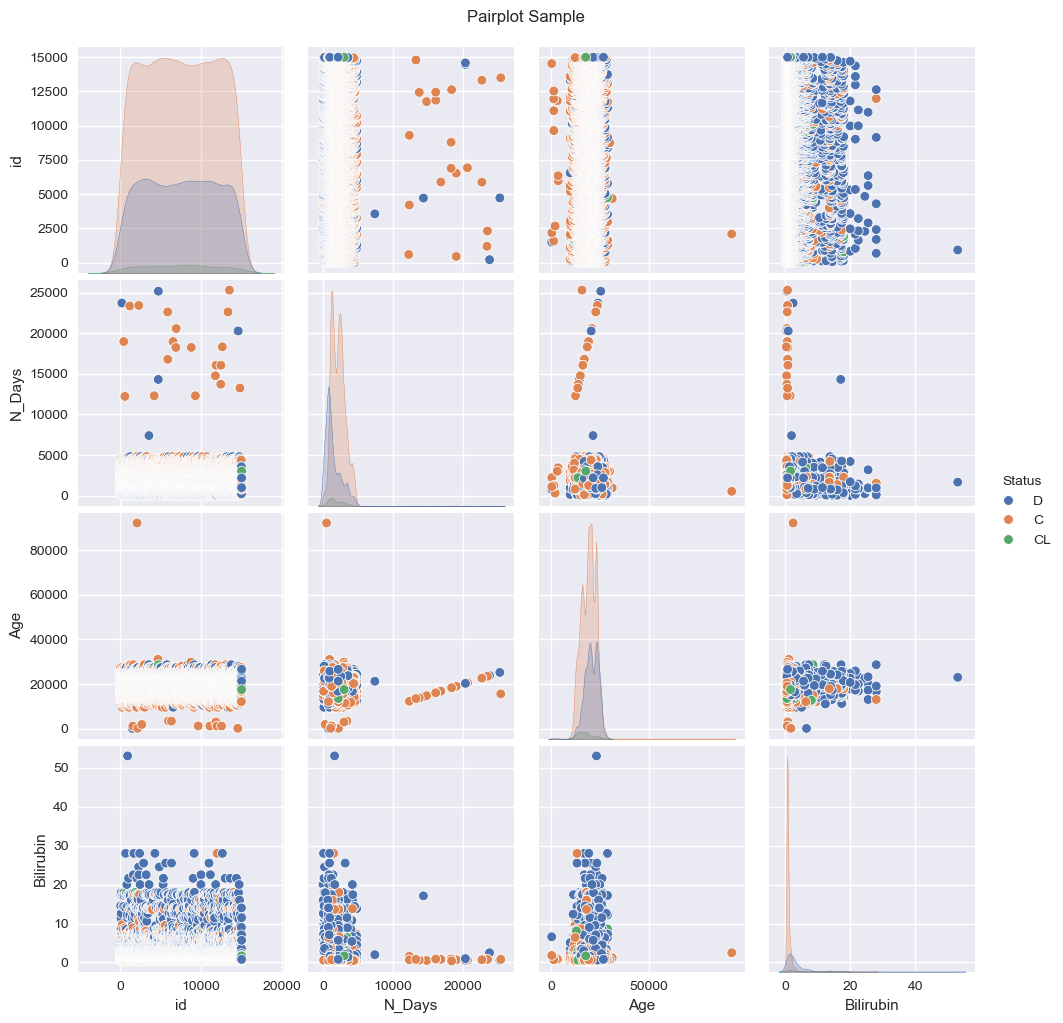

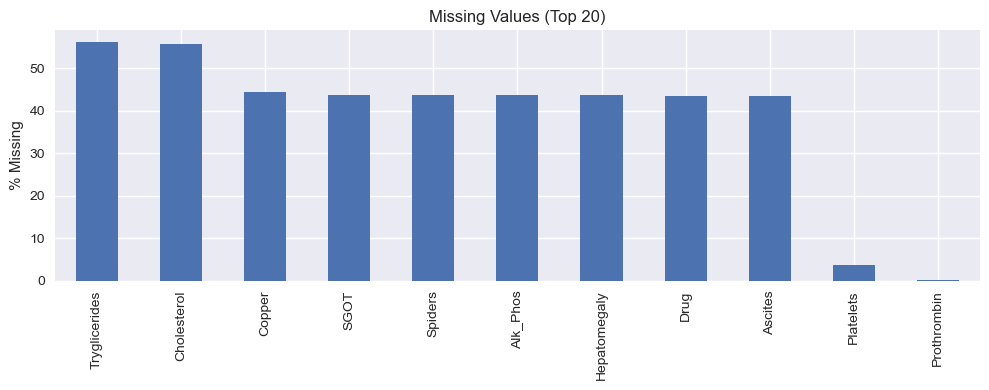

In [3]:
#EXPLORATORY DATA ANALYSIS (EDA)


print("Running enhanced EDA...")


plt.style.use("seaborn-v0_8")
sns.set_palette("deep")

# ---- BASIC STRUCTURE ----
print("Shape:", train_df.shape)
print("\nData Types:\n", train_df.dtypes)
print("\nHead:\n", train_df.head())
print("\nTail:\n", train_df.tail())

# Unique counts per column
print("\nUnique Values Per Column:")
print(train_df.nunique())

# Missing values table
missing_tbl = train_df.isna().sum().to_frame("missing")
missing_tbl["percent"] = (missing_tbl["missing"] / len(train_df)) * 100
print("\nMissing Value Summary:\n", missing_tbl)

# ---- TARGET DISTRIBUTION ----
if TARGET_COL in train_df.columns:
    plt.figure(figsize=(5, 3))
    sns.countplot(x=train_df[TARGET_COL])
    plt.title("Target Distribution")
    plt.tight_layout()
    plt.show()

    target_pct = train_df[TARGET_COL].value_counts(normalize=True) * 100
    print("\nTarget Class Percentages:\n", target_pct)

# ---- NUMERIC FEATURES ----
num_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()

if len(num_cols) > 0:
    print("\nNumeric Stats (with skew & kurtosis):")
    stats = train_df[num_cols].describe().T
    stats["skew"] = train_df[num_cols].skew()
    stats["kurtosis"] = train_df[num_cols].kurtosis()
    print(stats)

    # Histograms
    train_df[num_cols].hist(figsize=(14, 10), bins=20)
    plt.suptitle("Histograms of Numeric Features", y=1.02)
    plt.tight_layout()
    plt.show()

    # Boxplots for detecting outliers
    plt.figure(figsize=(14, len(num_cols) * 0.6))
    train_df[num_cols].plot(kind="box", subplots=True, layout=(len(num_cols)//3+1, 3),
                            figsize=(14, 12), sharex=False, sharey=False)
    plt.suptitle("Boxplots for Outlier Inspection", y=1.02)
    plt.tight_layout()
    plt.show()

# ---- CATEGORICAL FEATURES ----
cat_cols = train_df.select_dtypes(include=["object", "category"]).columns.tolist()

if cat_cols:
    for col in cat_cols:
        if col == TARGET_COL:
            continue
        plt.figure(figsize=(6, 3))
        sns.countplot(x=train_df[col])
        plt.title(f"Distribution of {col}")
        plt.tight_layout()
        plt.show()

# ---- CORRELATION ANALYSIS ----
if len(num_cols) >= 2:
    corr = train_df[num_cols].corr(numeric_only=True)
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, cmap="coolwarm", annot=False)
    plt.title("Correlation Heatmap")
    plt.tight_layout()
    plt.show()

# ---- FEATURE VS TARGET ----
if TARGET_COL in train_df.columns and len(num_cols) > 0:
    for col in num_cols:
        plt.figure(figsize=(6, 3))
        sns.boxplot(x=train_df[TARGET_COL], y=train_df[col])
        plt.title(f"{col} by {TARGET_COL}")
        plt.tight_layout()
        plt.show()

# ---- PAIRPLOT (only for a few columns) ----
sample_cols = num_cols[:4]
if len(sample_cols) > 1:
    sns.pairplot(train_df[sample_cols + [TARGET_COL]], hue=TARGET_COL, diag_kind="kde")
    plt.suptitle("Pairplot Sample", y=1.02)
    plt.show()

# ---- MISSINGNESS VISUAL (Top 20) ----
missing_pct = train_df.isna().mean().sort_values(ascending=False)
missing_pct = missing_pct[missing_pct > 0]

if not missing_pct.empty:
    plt.figure(figsize=(10, 4))
    (missing_pct.head(20) * 100).plot(kind="bar")
    plt.ylabel("% Missing")
    plt.title("Missing Values (Top 20)")
    plt.tight_layout()
    plt.show()


In [7]:
#MERGE, REPROCESSING, and FEATURE ENGINEERING STEPS


print("[Preprocessing] Starting feature engineering and encoding...")

# Preserve test ids before combining
test_ids = test_df["id"]

# Mark train/test
train_df["is_test"] = 0
test_df["is_test"] = 1

# Target
y = train_df["Status"]

# Combine (remove target only from train)
data = pd.concat(
    [train_df.drop(columns=["Status"]), test_df],
    ignore_index=True
)

# Missing values before
missing_before = int(data.isna().sum().sum())

# 1. Impute Missing Values
num_cols = data.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = data.select_dtypes(include=["object"]).columns.tolist()

for col in num_cols:
    data[col].fillna(data[col].median(), inplace=True)

for col in cat_cols:
    data[col].fillna("Missing", inplace=True)

missing_after = int(data.isna().sum().sum())
print(f"[Preprocessing] Imputed missing values: before={missing_before:,} | after={missing_after:,}")
print(f"[Preprocessing] Numeric cols={len(num_cols)} | Categorical cols={len(cat_cols)}")

# 2. Advanced Feature Engineering
skewed_cols = [
    "Bilirubin", "Cholesterol", "Alk_Phos", "SGOT",
    "Tryglicerides", "Prothrombin", "Copper"
]

created_log_feats = []
for col in skewed_cols:
    if col in data.columns:
        new_col = f"Log_{col}"
        data[new_col] = np.log1p(data[col])
        created_log_feats.append(new_col)

print(f"[Preprocessing] Created log features: {len(created_log_feats)} -> {created_log_feats if created_log_feats else 'None'}")

# Domain-specific ratios
data["Bili_Alb_Ratio"] = data["Bilirubin"] / (data["Albumin"] + 1e-6)
data["Prothr_Plat_Ratio"] = data["Prothrombin"] / (data["Platelets"] + 1e-6)
data["Diagnosis_Date"] = data["Age"] - data["N_Days"]
print("[Preprocessing] Added ratio/date features: Bili_Alb_Ratio, Prothr_Plat_Ratio, Diagnosis_Date")

# 3. Encoding
# Encode target
le = LabelEncoder()
y_encoded = le.fit_transform(y)
class_map = {i: cls for i, cls in enumerate(le.classes_)}
print(f"[Encoding] Target classes ({len(le.classes_)}): {class_map}")

# One-hot encode categorical features
shape_before = data.shape
data = pd.get_dummies(data, columns=cat_cols, drop_first=True)
shape_after = data.shape
print(f"[Encoding] One-hot encoded {len(cat_cols)} columns: shape {shape_before} -> {shape_after}")

# Cleanup
if "id" in data.columns:
    data = data.drop(columns=["id"])
    print("[Cleanup] Dropped 'id' column.")
else:
    print("[Cleanup] 'id' column not present after encoding.")

# --- DATA SPLIT ---
X_train = data[data["is_test"] == 0].drop(columns=["is_test"]).values
X_test = data[data["is_test"] == 1].drop(columns=["is_test"]).values
print(f"[Split] X_train={X_train.shape} | X_test={X_test.shape} | Features={X_train.shape[1]}")




[Preprocessing] Starting feature engineering and encoding...
[Preprocessing] Imputed missing values: before=105,710 | after=0
[Preprocessing] Numeric cols=14 | Categorical cols=6
[Preprocessing] Created log features: 7 -> ['Log_Bilirubin', 'Log_Cholesterol', 'Log_Alk_Phos', 'Log_SGOT', 'Log_Tryglicerides', 'Log_Prothrombin', 'Log_Copper']
[Preprocessing] Added ratio/date features: Bili_Alb_Ratio, Prothr_Plat_Ratio, Diagnosis_Date
[Encoding] Target classes (3): {0: 'C', 1: 'CL', 2: 'D'}
[Encoding] One-hot encoded 6 columns: shape (25000, 30) -> (25000, 36)
[Cleanup] Dropped 'id' column.
[Split] X_train=(15000, 34) | X_test=(10000, 34) | Features=34


In [ ]:
#MODEL DEFINITION

print("Initializing model configurations...")

# 1. XGBoost (updated)
xgb_params = {
    "n_estimators": 6800,
    "learning_rate": 0.002,
    "max_depth": 5,
    "num_leaves": 63,  # you included this
    "subsample": 0.8,
    "colsample_bytree": 0.9,
    "objective": "multi:softprob",
    "eval_metric": "mlogloss",
    "random_state": RANDOM_STATE,
    "n_jobs": -1,
    "tree_method": "hist",
}

# 2. LightGBM (updated)
lgbm_params = {
    "n_estimators": 5200,
    "learning_rate": 0.009,
    "max_depth": 8,
    "num_leaves": 63,
    "subsample": 0.9,
    "colsample_bytree": 0.000009,
    "objective": "multiclass",
    "metric": "multi_logloss",
    "random_state": RANDOM_STATE,
    "n_jobs": -1,
    "verbose": -1,
}

# 3. CatBoost (updated)
cat_params = {
    "iterations": 3700,
    "learning_rate": 0.030,
    "depth": 5,
    "loss_function": "MultiClass",
    "verbose": 0,
    "random_seed": RANDOM_STATE,
    "allow_writing_files": False,
}

# Instantiate models
xgb_model = XGBClassifier(**xgb_params)
lgbm_model = LGBMClassifier(**lgbm_params)
cat_model = CatBoostClassifier(**cat_params)

# Brief summaries
print(f"[Models] XGB param keys: {sorted(list(xgb_params.keys()))}")
print(f"[Models] LGBM param keys: {sorted(list(lgbm_params.keys()))}")
print(f"[Models] CatBoost param keys: {sorted(list(cat_params.keys()))}")
print("[Models] Model objects created: xgb_model, lgbm_model, cat_model")


In [ ]:
# Enhanced Voting Ensemble
ensemble = VotingClassifier(
    estimators=[
        ("xgb", xgb_model),
        ("lgbm", lgbm_model),
        ("cat", cat_model)
    ],
    voting="soft",
    weights=[1.9, 4.6, 2.6],     
    n_jobs=-1,
    flatten_transform=False
)


In [ ]:
#CROSS VALIDATION TRAINING
kf = StratifiedKFold(n_splits=8, shuffle=True, random_state=41)

kf = StratifiedKFold(
    n_splits=8,
    shuffle=True,
    random_state=41
)

# Number of classes
n_classes = len(np.unique(y_encoded))

# Preallocate OOF + Test preds
oof_preds = np.zeros((X_train.shape[0], n_classes))
test_preds = np.zeros((X_test.shape[0], n_classes))

print(f"[Training] Folds=8 | Features={X_train.shape[1]} | Classes={n_classes}")

fold_losses = []
start_time = time()

for fold, (tr, val) in enumerate(kf.split(X_train, y_encoded), start=1):
    X_tr, X_val = X_train[tr], X_train[val]
    y_tr, y_val = y_encoded[tr], y_encoded[val]

    print(f"[Training][Fold {fold}/8] Fitting ensemble...")
    ensemble.fit(X_tr, y_tr)

    # Predict OOF
    val_pred = ensemble.predict_proba(X_val)
    oof_preds[val] = val_pred

    # Add averaged test preds
    test_preds += ensemble.predict_proba(X_test) / 8

    fold_loss = log_loss(y_val, val_pred)
    fold_losses.append(fold_loss)

    print(f"[Training][Fold {fold}/8] LogLoss: {fold_loss:.5f}")

# OOF logloss
final_logloss = log_loss(y_encoded, oof_preds)
elapsed = time() - start_time

print("\n[Training] Completed.")
print(f"LogLoss: {final_logloss:.4f}")
print(
    f"[Training] fold_mean={np.mean(fold_losses):.5f} | "
    f"std={np.std(fold_losses):.4f} | "
    f"min={np.min(fold_losses):.4f} | "
    f"max={np.max(fold_losses):.4f}"
)
print(f"[Training] Time elapsed: {elapsed:.1f}s")


[Training] Folds=8 | Features=34 | Classes=3
[Training][Fold 1/8] Fitting ensemble...
[Training][Fold 1/8] LogLoss: 0.34006
[Training][Fold 2/8] Fitting ensemble...
[Training][Fold 2/8] LogLoss: 0.34017
[Training][Fold 3/8] Fitting ensemble...
[Training][Fold 3/8] LogLoss: 0.37254
[Training][Fold 4/8] Fitting ensemble...
[Training][Fold 4/8] LogLoss: 0.34342
[Training][Fold 5/8] Fitting ensemble...


In [ ]:
#CONFUSION MATRIX

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

print("Computing performance metrics")

# Predicted class from OOF probabilities
y_pred_oof = np.argmax(oof_preds, axis=1)

# Metrics
acc = accuracy_score(y_encoded, y_pred_oof)
print(f"[Metrics] OOF Accuracy: {acc:.4f}")
print("[Metrics] Classification Report (OOF):")
print(classification_report(y_encoded, y_pred_oof, target_names=list(le.classes_)))

# Confusion Matrix
cm = confusion_matrix(y_encoded, y_pred_oof)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix (OOF)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

In [ ]:
#SUBMISSION

# --- SUBMISSION ---
submission_df = pd.DataFrame(
    test_preds, columns=[f"Status_{cls}" for cls in le.classes_]
)
submission_df.insert(0, "id", test_ids)
submission_df = submission_df[["id", "Status_C", "Status_CL", "Status_D"]]

# Clip probabilities to prevent infinite logloss penalties
EPS = 1e-15
cols = ["Status_C", "Status_CL", "Status_D"]
submission_df[cols] = submission_df[cols].clip(EPS, 1 - EPS)
# Normalize rows to sum to 1
submission_df[cols] = submission_df[cols].div(submission_df[cols].sum(axis=1), axis=0)

submission_df.to_csv("../submissions/submission_optimized.csv", index=False)
print("Submission file 'submission_optimized.csv' generated.")
